In [1]:
import pandas as pd
import cobra as cb
import numpy as np

from reframed.cobra.transcriptomics import gene_to_reaction_expression, GIMME
from reframed import from_cobrapy
from cobra.flux_analysis.variability import find_essential_reactions

## Load expression data

In [2]:
expression_data_pseudomonas = { 'Carbon_Study' : {'m9-EX_cit_e:7.44' : ['SRX4552613',
                                                                        'SRX4552614',
                                                                        'SRX4552615'],
                                                  'm9-EX_fer_e:2.91' : ['SRX4552616',      #Experimentally measured in 0.1 glu
                                                                        'SRX4552617',
                                                                        'SRX4552618'],
                                                  'm9-EX_glc_e:7.44' : ['SRX4552619',      #Experimentally measured in 0.1 glu
                                                                        'SRX4552621'],
                                                  'm9-EX_ser__L_e:14.88' : ['SRX4552622',
                                                                            'SRX4552623',
                                                                            'SRX4552624'] },
                                'Aromatics_Study' : {'m9-EX_T4hcinnm_e:4.04' : ['SBRG_UNeb__coum__1',            #Experimentally measured in 0.1 glu
                                                                                'SBRG_UNeb__coum__2',
                                                                                'SBRG_UNeb__coum__3'], 
                                                     'm9-EX_T4hcinnm_e:2.02-EX_fer_e:1.4505' : ['SBRG_UNeb__coumferul__1', #Derived
                                                                                                'SBRG_UNeb__coumferul__2',
                                                                                                'SBRG_UNeb__coumferul__3'],  
                                                     'm9-EX_fer_e:2.91' : ['SBRG_UNeb__ferulate__1',            #Experimentally measured in 0.1 glu
                                                                           'SBRG_UNeb__ferulate__2',
                                                                           'SBRG_UNeb__ferulate__3'],  
                                                     'm9-EX_glc_e:7.44' : ['SBRG_UNeb__glc__1',                 #Experimentally measured in 0.1 glu
                                                                           'SBRG_UNeb__glc__2',
                                                                           'SBRG_UNeb__glc__3'] },
                                'Muconate_Study' : {'m9-EX_glc_e:7.44' : ['KT2440_glu_1',                 #Experimentally measured in 0.1 glu
                                                                          'KT2440_glu_2',
                                                                          'KT2440_glu_3'],
                                                    'm9-EX_glcn_e:7.44':['KT2440_glc_1',                 
                                                                         'KT2440_glc_2',
                                                                         'KT2440_glc_3'],
                                                    'm9-EX_fru_e:1.32' :['KT2440_f_1',                   #Multiplying the ratio of glucose and fructose
                                                                         'KT2440_f_2',                   #fluxes found in 0.3 glu by the glu flux in 0.1
                                                                         'KT2440_f_3'],                  #glu
                                                    'm9-EX_glc_e:3.72-EX_glcn_e:3.72' : ['KT2440_gg_1',
                                                                                         'KT2440_gg_2',
                                                                                         'KT2440_gg_3'],
                                                    'm9-EX_glc_e:3.72-EX_fru_e:0.66':['KT2440_fg_1',
                                                                                      'KT2440_fg_2',
                                                                                      'KT2440_fg_3'],
                                                    'm9-EX_glc_e:2.48-EX_glcn_e:2.48-EX_fru_e:0.44' : ['KT2440_gfg_1',
                                                                                                       'KT2440_gfg_2',
                                                                                                       'KT2440_gfg_3'] },
                                'Multistress_Study' : {'m9-EX_glc_e:7.44-control' : ['SRX2012748',
                                                                                     'SRX2012749',
                                                                                     'SRX2012750'],
                                                      'm9-EX_glc_e:7.44-osmotic_stress_7min' : ['SRX2012751',
                                                                                                'SRX2012753',
                                                                                                'SRX2012755'],
                                                      'm9-EX_glc_e:7.44-osmotic_stress_60min' : ['SRX2012752',
                                                                                                 'SRX2012754',
                                                                                                 'SRX2012756'],
                                                      'm9-EX_glc_e:7.44-imipenem_7min' : ['SRX2012757',
                                                                                          'SRX2012759',
                                                                                          'SRX2012761'],
                                                      'm9-EX_glc_e:7.44-imipenem_60min' : ['SRX2012758',
                                                                                           'SRX2012760',
                                                                                           'SRX2012762'],
                                                      'm9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stress_7min' : ['SRX2012763',
                                                                                                                'SRX2012765',
                                                                                                                'SRX2012767'],
                                                      'm9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stress_60min' : ['SRX2012764',
                                                                                                                 'SRX2012766',
                                                                                                                 'SRX2012768']},
                                'Phase_Study' : {'lb-wt_transition_phase' : ['SRX2020724',
                                                                             'SRX2020727',
                                                                             'SRX2021820',
                                                                             'SRX2021821'],
                                                'lb-wt_exponential_phase' : ['SRX2021818',
                                                                             'SRX2021819'],
                                                'lb-wt_stationary_phase' : ['SRX2021822',
                                                                            'SRX2021823']},
                                'Carbon2_Study' : {'m9-EX_glc_e:7.44' : ['SRX7195897',        #Experimentally measured in 0.1 glu
                                                                         'SRX7195898',
                                                                         'SRX7195899'],
                                                  'm9-EX_T4hcinnm_e:4.04' : ['SRX7195900',
                                                                             'SRX7195901',
                                                                             'SRX7195902']},  #Experimentally measured in 0.1 glu
                                'Myristic_acid_Study' : {'m9-EX_glc_e:7.44-control' : ['SRX4364709',
                                                                                       'SRX4364710',
                                                                                       'SRX4364711'],
                                                        'm9-EX_ttdca_e:3.19-myristic_acid' : ['SRX4364712',
                                                                                              'SRX4364713',
                                                                                              'SRX4364714']},
                                'Zinc_Study' : {'cdm-no_metals_control' : ['SRX7747534',
                                                                           'SRX7747535',
                                                                           'SRX7747536'],
                                               'cdm-EX_zn2_e:1-no_metals_zinc' : ['SRX7747531',
                                                                                  'SRX7747532',
                                                                                  'SRX7747533']}
                              }

studies = [study for study in expression_data_pseudomonas]

conditions_to_discard = set(["m9-EX_glc_e:7.44-imipenem_7min",
                             "m9-EX_glc_e:7.44-imipenem_60min",
                             "lb-wt_transition_phase",
                             "lb-wt_exponential_phase",
                             "lb-wt_stationary_phase",
                             "cdm-no_metals_control",
                             "cdm-EX_zn2_e:1-no_metals_zinc"])

samples = set([v for study in studies
               for condition in expression_data_pseudomonas[study]
               for v in expression_data_pseudomonas[study][condition]
               if condition not in conditions_to_discard])

gene_column = ["Geneid"] 
RNASEQ_data = pd.read_csv("data/log_tpm.csv")[gene_column+list(samples)]
RNASEQ_data

Geneid  SRX4364712  SRX2012755  SRX2012767  SRX2012754  \
0     PP_0001    7.407831    6.734255    6.575010    7.198811   
1     PP_0002    8.058821    7.091975    6.118530    7.578627   
2     PP_0003    8.534611    6.986216    6.873147    7.894943   
3     PP_0004    7.733427    6.619491    5.605141    7.865847   
4     PP_0005    4.828459    4.626101    5.306805    5.299056   
...       ...         ...         ...         ...         ...   
5559  PP_5416   11.768855   10.731467   10.117304    9.766325   
5560  PP_5417   12.535620   11.345777   10.018705    9.944965   
5561  PP_5418   12.982112   10.971622    9.146626    9.414179   
5562  PP_5419   10.410748    9.466269    7.025682    8.778850   
5563  PP_5420    9.382672    8.278574    6.935981    8.416462   

      SBRG_UNeb__glc__2  KT2440_gfg_2  SRX4552624  SBRG_UNeb__ferulate__1  \
0              7.945631      7.230665    6.739965                7.565750   
1              5.869078      6.493764    6.039715                5.595589   
2              6.010866      5.823821    7.061938                6.159036   
3              6.571713      6.582309    5.006455                6.730339   
4              5.752589      4.950381    4.868778                5.826814   
...                 ...           ...         ...                     ...   
5559          11.152989     11.612052    9.221719               10.066074   
5560          10.669517     11.222589   10.104304                9.709495   
5561           9.547925     10.052930    8.538867                8.768490   
5562           7.779898      8.984278    7.280454                7.263126   
5563           7.833268      9.472917    9.218860                8.250952   

      KT2440_glu_2  ...  SRX2012749  SBRG_UNeb__coumferul__2  SRX4552614  \
0         7.663466  ...    7.334702                 7.209110    6.794668   
1         6.121612  ...    7.578042                 5.425408    7.282862   
2         5.917183  ...    7.741569                 5.874020    7.328653   
3         6.440919  ...    7.262478                 6.316434    6.649527   
4         4.771618  ...    5.011125                 6.092754    5.979207   
...            ...  ...         ...                      ...         ...   
5559     11.147496  ...   11.436083                10.456375   10.863394   
5560     10.517116  ...   11.816195                 9.857874   11.064860   
5561      9.520070  ...   10.515139                 8.662391    9.946741   
5562      8.089881  ...    9.512027                 7.388682    8.593405   
5563      8.349604  ...    9.437585                 8.457082    9.213303   

      SRX2012756  KT2440_f_3  SRX7195899  SRX4552618  KT2440_fg_3  \
0       7.246303    7.601509    6.346777    7.276452     7.589084   
1       7.346774    6.495745    6.188782    6.625536     6.682529   
2       8.191215    6.408004    5.682633    7.833797     6.098005   
3       7.946256    6.563828    5.675485    6.114935     6.869877   
4       4.690328    5.183681    5.737015    4.255245     5.140639   
...          ...         ...         ...         ...          ...   
5559   10.098460   11.020720    8.818859   10.726869    11.527302   
5560   10.252322   10.357844    9.388401   11.129792    11.112960   
5561    9.382166    9.283280   10.163295    9.140893    10.157052   
5562    8.519027    8.115641    8.282567    8.396345     8.882273   
5563    8.829426    9.051330    8.104284    9.356045     8.303203   

      SBRG_UNeb__glc__1  KT2440_f_1  
0              7.846647    7.499569  
1              5.759097    7.001086  
2              6.124141    6.734859  
3              6.591880    7.221286  
4              5.240575    5.295455  
...                 ...         ...  
5559          10.989263   10.689632  
5560          10.463065   10.064582  
5561           9.608606    8.490772  
5562           7.536329    8.059028  
5563           7.721057    9.643210  

[5564 rows x 69 columns]

## Map expression and flux data

In [4]:
def set_medium(model, media_definition, carbon_source):
    model_with_media = model.copy()
    
    try:
        for source, uptake in carbon_source.items():
            media_definition[source] = uptake
            
        model_with_media.medium = media_definition
            
    except Exception as e:
        print(e)
        if type(carbon_source) != dict or type(media_definition) != dict:
            print("Both 'media_definition'  and 'carbon_source' must be a dict with pattern {<exchange_reaction> : <uptake_rate>}")
    
    return model_with_media

# Create a COBRA model from GIMME function with simplifications.
# Only reactions with a threshold expression are included and the reactions required to grow as well.
def create_simplified_GIMME_model(model,expression,cutoff=0.25):
    model_gimme=model.copy()
    rf_model = from_cobrapy(model)
    dict_out={}
    reaction_values=gene_to_reaction_expression(rf_model, expression)
    #Calculamos la expression minima para asumir funcionalidad
    # Pasamos de dict a numpy array
    expression_values= reaction_values.values()
    expression_values_list = list(expression_values) 
    expression_values_numpy = np.array(expression_values_list)
    threadshold=np.quantile(expression_values_numpy,cutoff)
    #Calculamos reacciones esenciales para no tenerlas en cuenta
    try:
        essential_reactions=cobra.flux_analysis.find_essential_reactions(model_gimme)
    except:
        essential_reactions=[]
        
    essential_reactions_ids=[reaction.id for reaction in essential_reactions]
    #Calculamos las reacciones que pasan del corte por expression
    for key,value in reaction_values.items():
        if value > threadshold:
            dict_out[key]=value
        else:
            if key not in essential_reactions_ids:
                old_bounds=model_gimme.reactions.get_by_id(key).bounds
                model_gimme.reactions.get_by_id(key).knock_out()
                # check if the solution of the model is infeasible or 0
                if model_gimme.slim_optimize()==0 or np.isnan(model_gimme.slim_optimize()):
                    model_gimme.reactions.get_by_id(key).bounds=old_bounds
                    dict_out[key]="Reinserted"
                else:
                    dict_out[key]="KO"
            else:
                dict_out[key]="Essential"
    # Deshabilitamos las reacciones que no han pasado el corte de expression
    for reaction,expression in reaction_values.items():
        if reaction not in dict_out:
            model_gimme.reactions.get_by_id(reaction).knock_out()
    return(dict_out,model_gimme)

In [5]:
models_dir = "models"
or_sep = " or "    # For GPR mapping
and_sep = " and "  # For GPR mapping

# Read WT model
ijn_1462 = cb.io.read_sbml_model("models/iJN1463.xml")

# Relevant genes and reactions in the analysis
aceK_geneid = "PP_4565"
target_reactions = ["ICL", "ICDHyr", "FUM", "CS", "SUCOAS"]
target_biomass = "BIOMASS_KT2440_WT3"
glucose_map = {"EX_glc_e" : "EX_glc__D_e"}
fum_reactions = [r.id for r in ijn_1462.reactions
                 if "fum_c" in [m.id for m in r.metabolites]]

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20


In [8]:
# Define data structures for saving analysis results
flux_data = { "Study" : [],
              "Condition" : [],
              "Reaction" : [],
              "GPR" : [],
              "Flux" : [],
              "Median_Log_TPM" : [],
              "aceK_Mean_Log_TPM" : []}

fum_reaction_data = { "Study" : [],
                      "Condition" : [],
                      "Reaction" : [],
                      "Flux" : []}

# Get the expression of genes in different conditions and use this data to
# contextualize the GEM and estimate reaction fluxes

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            #DEFINE MEDIUM
            media_definition = { 'EX_ca2_e' : 1000,
                                 'EX_cl_e' : 1000,
                                 'EX_co2_e' : 1000,
                                 'EX_cobalt2_e' : 1000,
                                 'EX_cu2_e' : 1000,
                                 'EX_fe2_e' : 1000,
                                 'EX_fe3_e' : 1000,
                                 'EX_h_e' : 1000,
                                 'EX_h2o_e' : 1000,
                                 'EX_k_e' : 1000,
                                 'EX_mg2_e' : 1000,
                                 'EX_mn2_e' : 1000,
                                 'EX_mobd_e' : 1000,
                                 'EX_na1_e' : 1000,
                                 'EX_tungs_e' : 1000,
                                 'EX_zn2_e' : 1000,
                                 'EX_ni2_e' : 1000,
                                 'EX_sel_e' : 1000,
                                 'EX_so4_e' : 1000,
                                 'EX_nh4_e' : 1000,
                                 'EX_pi_e' : 1.024,
                                 'EX_cbl1_e' : .01,
                                 'EX_o2_e' : 20 }
            
            print(condition)
            
            carbon_source = {s.split(':')[0] : float(s.replace('minus', '-').split(':')[1])
                             for s in condition.split('-')[1:]
                             if s.startswith('EX_')}
            
            if "EX_glc_e" in carbon_source.keys():
                uptake = carbon_source["EX_glc_e"]
                del carbon_source['EX_glc_e']
                
                carbon_source[glucose_map["EX_glc_e"]] = uptake
            
            #CONTEXTUALIZE GEM
            context_gem = set_medium(ijn_1462, media_definition, carbon_source) # Set medium
            replicates = expression_data_pseudomonas[study][condition]          # Get expression data and
            expression_median = {gene : np.median(ex_reps)                      # Use median expression for context
                                 for gene, ex_reps in zip(RNASEQ_data[gene_column[0]].values,
                                                          RNASEQ_data[replicates].values)}

            result_details, context_gem = create_simplified_GIMME_model(context_gem, expression_median, cutoff=0.1)            
            fba = context_gem.optimize()
            
            fum_with_flux = fba[fum_reactions].loc[fba.to_frame()["fluxes"]>0]
            
            for r_id, flux in fum_with_flux.iteritems():
                fum_reaction_data["Study"].append(study)
                fum_reaction_data["Condition"].append(condition)
                fum_reaction_data["Reaction"].append(r_id)
                fum_reaction_data["Flux"].append(flux)
            
            if fba[target_biomass]>0:
                for reaction in target_reactions:
                    gpr = context_gem.reactions.get_by_id(reaction).gpr.to_string()
                    
                    if "(" in gpr or ")" in gpr:
                        gpr = gpr.replace("(", "").replace(")", "")
                        
                    if "or" in gpr or "and" in gpr:
                        genes = set()
                        or_genes = gpr.split(or_sep)
                        
                        for g_s in or_genes:
                            genes |= set(g_s.split(and_sep))
                        
                        genes = list(genes)
                            
                    else:
                        genes = [gpr]
                    
                    flux_data["Study"].append(study)
                    flux_data["Condition"].append(condition)
                    flux_data["Reaction"].append(reaction)
                    flux_data["GPR"].append(gpr)
                    flux_data["Flux"].append(fba[reaction])
                    flux_data["Median_Log_TPM"].append([expression_median[gene] for gene in genes])                    
                    flux_data["aceK_Mean_Log_TPM"].append(expression_median[aceK_geneid])
                
flux_data = pd.DataFrame().from_dict(flux_data)
flux_data.head()

m9-EX_cit_e:7.44
Read LP format model from file /tmp/tmpr0b6gf73.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpewqj8de7.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
m9-EX_fer_e:2.91
Read LP format model from file /tmp/tmpxgxaa2xr.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpq884nw8t.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
m9-EX_glc_e:7.44
Read LP format model from file /tmp/tmpr_ycsn7n.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpmxv96m_o.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
m9-EX_ser__L_e:14.88
Read LP format model from file /tmp/tmpureab63b.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpt0ucjs5w.lp
Reading time = 0.01 seconds
: 

KeyboardInterrupt: 

In [30]:
flux_data.to_csv("Results/flux_vs_expression_data.csv", index=False)

In [7]:
fum_reaction_data = pd.DataFrame().from_dict(fum_reaction_data)
fum_reaction_data.head()

Study         Condition Reaction      Flux
0  Carbon_Study  m9-EX_cit_e:7.44    ARGSL  0.197777
1  Carbon_Study  m9-EX_cit_e:7.44    ASPO5  0.001271
2  Carbon_Study  m9-EX_cit_e:7.44      FUM  7.351130
3  Carbon_Study  m9-EX_cit_e:7.44    SUCDi  6.750293
4  Carbon_Study  m9-EX_cit_e:7.44   ADSL1r  0.172928

In [26]:
pd.set_option('display.max_rows', None)
fum_reaction_data.groupby(["Study", "Condition", "Reaction"]).sum()

Flux
Study               Condition                                          Reaction           
Aromatics_Study     m9-EX_T4hcinnm_e:2.02-EX_fer_e:1.4505              ADSL1r     0.128883
                                                                       ADSL2r     0.172463
                                                                       ARGSL      0.147403
                                                                       FUM        7.992851
                                                                       SUCDi      7.544103
                    m9-EX_T4hcinnm_e:4.04                              ADSL1r     0.141887
                                                                       ADSL2r     0.189865
                                                                       ARGSL      0.162276
                                                                       ASPO5      0.001043
                                                                       FUM        9.676634
                                                                       SUCDi      9.183649
                    m9-EX_fer_e:2.91                                   ADSL1r     0.115472
                                                                       ADSL2r     0.154518
                                                                       ARGSL      0.132065
                                                                       ASPO5      0.000848
                                                                       DHORDfum   0.123634
                                                                       FUM        6.363637
                                                                       SUCDi      6.086065
                    m9-EX_glc_e:7.44                                   ADSL1r     0.224796
                                                                       ADSL2r     0.300809
                                                                       ARGSL      0.257098
                                                                       ASPO5      0.001652
                                                                       FUM        4.230897
                                                                       SUCDi      3.449847
Carbon2_Study       m9-EX_T4hcinnm_e:4.04                              ADSL1r     0.142169
                                                                       ADSL2r     0.190243
                                                                       ARGSL      0.162599
                                                                       FUM       10.509395
                                                                       SUCDi     10.014384
                    m9-EX_glc_e:7.44                                   ADSL1r     0.224794
                                                                       ADSL2r     0.300807
                                                                       ARGSL      0.257097
                                                                       FUM        4.230954
                                                                       SUCDi      3.448255
Carbon_Study        m9-EX_cit_e:7.44                                   ADSL1r     0.172928
                                                                       ADSL2r     0.231402
                                                                       ARGSL      0.197777
                                                                       ASPO5      0.001271
                                                                       FUM        7.351130
                                                                       SUCDi      6.750293
                    m9-EX_fer_e:2.91                                   ADSL1r     0.115472
                                                                       ADSL2r     0.154518
                                                                       ARGSL      

In [27]:
fum_reaction_data.to_csv("Results/fum_reactions_data.csv", index=False)

# Plots

In [11]:
flux_data = pd.read_csv("results/flux_vs_expression_data.csv")
#fum_reaction_data = pd.read_csv("results/fum_reactions_data.csv")

In [12]:
flux_data.loc[flux_data["Reaction"].isin(["CS", "ICDHyr"])]

Study                                          Condition  \
1           Carbon_Study                                   m9-EX_cit_e:7.44   
3           Carbon_Study                                   m9-EX_cit_e:7.44   
6           Carbon_Study                                   m9-EX_fer_e:2.91   
8           Carbon_Study                                   m9-EX_fer_e:2.91   
11          Carbon_Study                                   m9-EX_glc_e:7.44   
13          Carbon_Study                                   m9-EX_glc_e:7.44   
16          Carbon_Study                               m9-EX_ser__L_e:14.88   
18          Carbon_Study                               m9-EX_ser__L_e:14.88   
21       Aromatics_Study                              m9-EX_T4hcinnm_e:4.04   
23       Aromatics_Study                              m9-EX_T4hcinnm_e:4.04   
26       Aromatics_Study              m9-EX_T4hcinnm_e:2.02-EX_fer_e:1.4505   
28       Aromatics_Study              m9-EX_T4hcinnm_e:2.02-EX_fer_e:1.4505   
31       Aromatics_Study                                   m9-EX_fer_e:2.91   
33       Aromatics_Study                                   m9-EX_fer_e:2.91   
36       Aromatics_Study                                   m9-EX_glc_e:7.44   
38       Aromatics_Study                                   m9-EX_glc_e:7.44   
41        Muconate_Study                                   m9-EX_glc_e:7.44   
43        Muconate_Study                                   m9-EX_glc_e:7.44   
46        Muconate_Study                                  m9-EX_glcn_e:7.44   
48        Muconate_Study                                  m9-EX_glcn_e:7.44   
51        Muconate_Study                                   m9-EX_fru_e:1.32   
53        Muconate_Study                                   m9-EX_fru_e:1.32   
56        Muconate_Study                    m9-EX_glc_e:3.72-EX_glcn_e:3.72   
58        Muconate_Study                    m9-EX_glc_e:3.72-EX_glcn_e:3.72   
61        Muconate_Study                     m9-EX_glc_e:3.72-EX_fru_e:0.66   
63        Muconate_Study                     m9-EX_glc_e:3.72-EX_fru_e:0.66   
66        Muconate_Study      m9-EX_glc_e:2.48-EX_glcn_e:2.48-EX_fru_e:0.44   
68        Muconate_Study      m9-EX_glc_e:2.48-EX_glcn_e:2.48-EX_fru_e:0.44   
71     Multistress_Study                           m9-EX_glc_e:7.44-control   
73     Multistress_Study                           m9-EX_glc_e:7.44-control   
76     Multistress_Study               m9-EX_glc_e:7.44-osmotic_stress_7min   
78     Multistress_Study               m9-EX_glc_e:7.44-osmotic_stress_7min   
81     Multistress_Study              m9-EX_glc_e:7.44-osmotic_stress_60min   
83     Multistress_Study              m9-EX_glc_e:7.44-osmotic_stress_60min   
86     Multistress_Study  m9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stres...   
88     Multistress_Study  m9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stres...   
91     Multistress_Study  m9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stres...   
93     Multistress_Study  m9-EX_glc_e:7.44-EX_h2o2_e:0.5-oxidative_stres...   
96         Carbon2_Study                                   m9-EX_glc_e:7.44   
98         Carbon2_Study                                   m9-EX_glc_e:7.44   
101        Carbon2_Study                              m9-EX_T4hcinnm_e:4.04   
103        Carbon2_Study                              m9-EX_T4hcinnm_e:4.04   
106  Myristic_acid_Study                           m9-EX_glc_e:7.44-control   
108  Myristic_acid_Study                           m9-EX_glc_e:7.44-control   
111  Myristic_acid_Study                   m9-EX_ttdca_e:3.19-myristic_acid   
113  Myristic_acid_Study                   m9-EX_ttdca_e:3.19-myristic_acid   

    Reaction                 GPR       Flux               Median_Log_TPM  \
1     ICDHyr  PP_4012 or PP_4011   6.911590   [9.096585586, 8.745738402]   
3         CS             PP_4194   0.000000                 [9.20714713]   
6     ICDHyr  PP_4012 or PP_4011   2.455103   [7.201913793, 7.965851524]   
8

### Correlation of ICL expression with its flux

In [13]:
from scipy.stats import pearsonr
import plotly.express as px
import numpy as np
from ast import literal_eval

plot_df = flux_data[flux_data["Reaction"]=="ICL"]
plot_df["Median_Log_TPM"] = [literal_eval(v)[0] for v in plot_df["Median_Log_TPM"]]

fig = px.scatter(plot_df, x="Median_Log_TPM", y="Flux", color="Condition")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900,
                  title="ICL Flux vs Expression")

fig.show()

/tmp/ipykernel_478514/2308472303.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["Median_Log_TPM"] = [literal_eval(v)[0] for v in plot_df["Median_Log_TPM"]]


In [38]:
pearsonr(plot_df["Median_Log_TPM"].values,
         plot_df["Flux"].values)

(0.634201340747487, 0.0011545302709443069)

In [39]:
pearsonr(plot_df.loc[plot_df["Median_Log_TPM"]<6]["Median_Log_TPM"].values,
         plot_df.loc[plot_df["Median_Log_TPM"]<6]["Flux"].values)

(-0.23962058412755902, 0.4093087442166917)

In [40]:
pearsonr(plot_df.loc[plot_df["Median_Log_TPM"]>6]["Median_Log_TPM"].values,
         plot_df.loc[plot_df["Median_Log_TPM"]>6]["Flux"].values)

(0.941600691659595, 0.00014963892277294175)

The flux of ICL reaction is moderately correlated with the median expression of their genes across conditions. It seems that when expression levels are low no correlation exists. However, for moderate to high expression levels, this correlation became strong (**R$^{2}$=0.94**).

### ICL expression vs the other genes

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

fig = make_subplots(rows=3, cols=3, shared_yaxes=True)

df_ICL = flux_data[flux_data["Reaction"]=="ICL"]
df_ICL["Median_Log_TPM"] = [literal_eval(v)[0] for v in df_ICL["Median_Log_TPM"]]

df_PP_4011 = flux_data[flux_data["Reaction"]=="ICDHyr"]
df_PP_4011["Median_Log_TPM"] = [literal_eval(v)[0] for v in df_PP_4011["Median_Log_TPM"]]

df_PP_4012 = flux_data[flux_data["Reaction"]=="ICDHyr"]
df_PP_4012["Median_Log_TPM"] = [literal_eval(v)[1] for v in df_PP_4012["Median_Log_TPM"]]

df_CS = flux_data[flux_data["Reaction"]=="CS"]
df_CS["Median_Log_TPM"] = [literal_eval(v)[0] for v in df_CS["Median_Log_TPM"]]

df_PP_0897 = flux_data[flux_data["Reaction"]=="FUM"]
df_PP_0897["Median_Log_TPM"] = [literal_eval(v)[2] for v in df_PP_0897["Median_Log_TPM"]]

df_PP_1755 = flux_data[flux_data["Reaction"]=="FUM"]
df_PP_1755["Median_Log_TPM"] = [literal_eval(v)[1] for v in df_PP_1755["Median_Log_TPM"]]

df_PP_0944 = flux_data[flux_data["Reaction"]=="FUM"]
df_PP_0944["Median_Log_TPM"] = [literal_eval(v)[0] for v in df_PP_0944["Median_Log_TPM"]]


fig.append_trace(go.Scatter(x=df_PP_4011["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs PP_4011"), col=1, row=1)

fig.append_trace(go.Scatter(x=df_ICL["aceK_Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs aceK"), col=2, row=1)

fig.append_trace(go.Scatter(x=df_PP_4012["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs PP_4012"), col=3, row=1)

fig.append_trace(go.Scatter(x=df_CS["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs CS"), col=1, row=2)

fig.append_trace(go.Scatter(x=df_PP_0897["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs PP_0897"), col=2, row=2)

fig.append_trace(go.Scatter(x=df_PP_1755["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs PP_1755"), col=3, row=2)

fig.append_trace(go.Scatter(x=df_PP_0944["Median_Log_TPM"],
                            y=df_ICL["Median_Log_TPM"],
                            mode="markers",
                            name="ICL vs PP_0944"), col=1, row=3)


'''            
fig.update_scenes(xaxis_title_text='ICD/IDH (PP_4011/PP_4012) expression',  
                  yaxis_title_text='ICL (PP_4116) expression',  
                  zaxis_title_text='aceK (PP_4565) expression')
'''

fig.update_yaxes(title="ICL Expression", col=1, row=1)
fig.update_yaxes(title="ICL Expression", col=1, row=2)
fig.update_yaxes(title="ICL Expression", col=1, row=3)

fig.update_xaxes(title="PP_4011 Expression", col=1, row=1)
fig.update_xaxes(title="aceK Expression", col=2, row=1)
fig.update_xaxes(title="PP_4012 Expression", col=3, row=1)
fig.update_xaxes(title="PP_4194 Expression", col=1, row=2)
fig.update_xaxes(title="PP_0897 Expression", col=2, row=2)
fig.update_xaxes(title="PP_1755 Expression", col=3, row=2)
fig.update_xaxes(title="PP_0944 Expression", col=1, row=3)

fig.update_layout(template="simple_white",
                  height=800,
                  width=900)

fig.show()

## Correlation between PP_1755 (one of the FUM genes) and aceK expression

In [15]:
import plotly.graph_objects as go

raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4565"],
                         y=raw_RNASEQ_data["PP_1755"],
                         marker_color="rgb(255,153,153)",
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4565"], raw_RNASEQ_data["PP_1755"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4565 (aceK)",
                  yaxis_title="log(TPM) of PP_1755 (fumC2)"
                  )

fig.show()

In [61]:
fig.write_image("aceK_FumC2_corr.svg")

## Correlation between aceK and ICD expression

In [16]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4565"],
                         y=raw_RNASEQ_data["PP_4011"],
                         marker_color="rgb(255,153,153)", #rgb(240,205,131)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4565"], raw_RNASEQ_data["PP_4011"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.05, y=0.99, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4565 (aceK)",
                  yaxis_title="log(TPM) of PP_4011 (icd)"
                  )

fig.show()

In [63]:
fig.write_image("aceK_icd_corr.svg")

## Correlation between PP_1755 and ICD expression

In [17]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_1755"],
                         y=raw_RNASEQ_data["PP_4011"],
                         marker_color="rgb(255,153,153)", #rgb(240,205,131)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_1755"], raw_RNASEQ_data["PP_4011"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.05, y=0.99, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_1755 (fumC2)",
                  yaxis_title="log(TPM) of PP_4011 (icd)"
                  )

fig.show()

In [65]:
fig.write_image("FumC2_icd_corr.svg")

## Correlation between CS and IDH expression

In [18]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4194"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4194"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.05, y=0.99, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4194 (CS)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [67]:
fig.write_image("CS_idh_corr.svg")

In [108]:
#fum vs idh
pearsonr(raw_RNASEQ_data["PP_1755"], raw_RNASEQ_data["PP_4012"])

(0.28657696448588477, 5.787791244201958e-11)

According to above results, the expression of *aceK, ICD* and *PP_1755* (one of the FUM genes) is correlated. However, *aceK* is known to regulate the activity of *ICD* through phosphorilation/dephosphorilation. That means that in absence of postranscriptional regulation, the implication of *ICD* on ICDHyr reaction will be dependent on *aceK* activity.

FUM and CS reactions will be coupled with ICDHyr reaction in terms of gene expression only when *aceK* activity do not hampers *ICD* activation or when ICDHyr reaction is carried out by *IDH*.

## Correlation between ICL and CS expression

In [54]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = px.scatter(raw_RNASEQ_data, x="PP_4116", y="PP_4194")

fig.update_layout(template="simple_white",
                  height=400,
                  width=600)

fig.show()

In [55]:
pearsonr(raw_RNASEQ_data["PP_4116"], raw_RNASEQ_data["PP_4194"])

(0.31463001447656674, 5.081503596830253e-13)

## Correlation between ICL and ICD expression

In [62]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = px.scatter(raw_RNASEQ_data, x="PP_4116", y="PP_4011")

fig.update_layout(template="simple_white",
                  height=400,
                  width=600)

fig.show()

In [19]:
pearsonr(raw_RNASEQ_data["PP_4116"], raw_RNASEQ_data["PP_4011"])

(0.2795966498661766, 1.7384225783891998e-10)

## Correlation between ICL and IDH expression

In [61]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = px.scatter(raw_RNASEQ_data, x="PP_4116", y="PP_4012")

fig.update_layout(template="simple_white",
                  height=400,
                  width=600)

fig.show()

In [58]:
pearsonr(raw_RNASEQ_data["PP_4116"], raw_RNASEQ_data["PP_4012"])

(0.10376638388580091, 0.01992622724249444)

## Correlation between ICD and IDH expression

In [70]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = px.scatter(raw_RNASEQ_data, x="PP_4011", y="PP_4012")

fig.update_layout(template="simple_white",
                  height=400,
                  width=600)

fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4011"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(0,178,132)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4011"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4011 (icd)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [71]:
fig.write_image("icd_idh_corr.svg")

While *IDH* gene seems to have a stable expression across conditions, *ICD* expression varies considerably more. This could suggest that the *IDH* gene is used for constitutive functions while *ICD* would play a role in condition-dependent functions, which is consistent with its regulation by *aceK*.

## Correlation between SUCOAS and ICD expression

In [61]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T

fig = px.scatter(raw_RNASEQ_data, x="PP_4185", y="PP_4011")

fig.update_layout(template="simple_white",
                  height=400,
                  width=600)

fig.show()

In [62]:
pearsonr(raw_RNASEQ_data["PP_4185"], raw_RNASEQ_data["PP_4011"])

(0.24649197155474906, 2.1295074496075295e-08)

## Correlation between SUCOAS and IDH expression

In [73]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4185"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4185"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4185 (sucD)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [74]:
fig.write_image("sucD_idh_corr.svg")

In [75]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_4186"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_4186"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_4186 (sucC)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [76]:
fig.write_image("sucC_idh_corr.svg")

With the expression comparision with SUCOAS genes it becames clear that *IDH* expression is correlated with the genes of upstream reaction CS and downstream SUCOAS, while *ICD* expression only correlates with FUM reaction genes. This points to *ICD* having a role out of the TCA normal functioning, potentially involving downstream reactions.

In [77]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_0897"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_0897"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_0897 (fumA)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [78]:
fig.write_image("fumA_idh_corr.svg")

In [21]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_0944"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_0944"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_0944 (fumC1)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [22]:
fig.write_image("fumC1_idh_corr.svg")

In [38]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_0944"],
                         y=raw_RNASEQ_data["PP_4011"],
                         marker_color="rgb(255,153,153)", #rgb(240,205,131)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_0944"], raw_RNASEQ_data["PP_4011"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.05, y=0.99, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_0944 (fumC1)",
                  yaxis_title="log(TPM) of PP_4011 (icd)"
                  )

fig.show()

In [39]:
fig.write_image("fumC1_icd_corr.svg")

In [65]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T


fig = go.Figure()
fig.add_trace(go.Scatter(x=raw_RNASEQ_data["PP_1755"],
                         y=raw_RNASEQ_data["PP_4012"],
                         marker_color="rgb(240,205,131)", #rgb(255,153,153)
                         mode="markers"))

corr, p_val = pearsonr(raw_RNASEQ_data["PP_1755"], raw_RNASEQ_data["PP_4012"])

fig.add_annotation(text=f"R2 : {round(corr, 3)}; p-Val: {np.format_float_scientific(p_val, exp_digits=3,precision=3)}",
                   xref="paper", yref="paper",
                   x=0.99, y=0.05, showarrow=False)

fig.update_layout(template="simple_white",
                  height=400,
                  width=400,
                  xaxis_title="log(TPM) of PP_1755 (fumC2)",
                  yaxis_title="log(TPM) of PP_4012 (idh)"
                  )

fig.show()

In [66]:
fig.write_image("fumC2_idh_corr.svg")

## Comparision of ICD, IDH, aceK, ICL, CS and FUM expression

In [65]:
df_PP_4012.rename(columns={"IDH_Mean_Log_TPM": "Mean_Log_TPM"}, inplace=True)
df_PP_4012["Gene"] = ["IDH"]*len(df_PP_4012)

df_PP_4011.rename(columns={"ICD_Mean_Log_TPM": "Mean_Log_TPM"}, inplace=True)
df_PP_4011["Gene"] = ["ICD"]*len(df_PP_4011)

df_CS.rename(columns={"CS_Mean_Log_TPM": "Mean_Log_TPM"}, inplace=True)
df_CS["Gene"] = ["CS"]*len(df_CS)

df_PP_1755.rename(columns={"PP_1755_Mean_Log_TPM": "Mean_Log_TPM"}, inplace=True)
df_PP_1755["Gene"] = ["PP_1755"]*len(df_PP_1755)

df_ICL["Gene"] = ["ICL"]*len(df_ICL)

plot_df = pd.concat([df_CS, df_ICL, df_PP_4012, df_PP_4011, df_PP_1755])
plot_df.loc[plot_df["Condition"]=="m9-EX_glc_e:7.44-control", "Condition"] = "m9-EX_glc_e:7.44"
plot_df.head()

Study              Condition Reaction      GPR      Flux  \
3      Carbon_Study       m9-EX_cit_e:7.44       CS  PP_4194  0.000000   
8      Carbon_Study       m9-EX_fer_e:2.91       CS  PP_4194  3.512979   
13     Carbon_Study       m9-EX_glc_e:7.44       CS  PP_4194  4.346232   
18     Carbon_Study   m9-EX_ser__L_e:14.88       CS  PP_4194  6.569795   
23  Aromatics_Study  m9-EX_T4hcinnm_e:4.04       CS  PP_4194  5.709551   

    Median_Log_TPM  aceK_Median_Log_TPM Gene  
3         9.207147             4.885805   CS  
8         8.889907             3.518591   CS  
13        9.218045             2.712496   CS  
18        7.761600             4.902920   CS  
23        8.264013             4.316814   CS

In [67]:
fig = px.bar(plot_df, x="Condition", y="Median_Log_TPM", 
             color="Gene", barmode="group", facet_row="Study")

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].split("_")[0]))

fig.for_each_yaxis(lambda y: y.update(title = ''))

fig.add_annotation(x=-0.05, y=0.5,
                   text="Median_Log_TPM", textangle=-90,
                    xref="paper", yref="paper")

fig.add_annotation(x=1.1, y=0.5,
                   text="Study", textangle=90,
                   xref="paper", yref="paper")

fig.update_layout(template="simple_white",
                  height=1000,
                  width=1000)

fig.show()

In [81]:
from scipy.stats import mannwhitneyu

display(plot_df.loc[plot_df["Condition"].str.contains("EX_glc_e")].groupby("Gene").median())

mannwhitneyu(plot_df.loc[(plot_df["Gene"]=="IDH")&(plot_df["Condition"].str.contains("EX_glc_e"))]["Median_Log_TPM"],
             plot_df.loc[(plot_df["Gene"]=="ICD")&(plot_df["Condition"].str.contains("EX_glc_e"))]["Median_Log_TPM"])

Flux  Median_Log_TPM  aceK_Median_Log_TPM
Gene                                                  
CS       4.346232        8.512750             3.638836
ICD      2.644417        7.517103             3.638836
ICL      1.701997        5.161806             3.638836
IDH      2.644417        8.627082             3.638836
PP_1755  4.230680        5.108849             3.638836

MannwhitneyuResult(statistic=128.0, pvalue=0.027445099375459536)

In [82]:
display(plot_df.loc[plot_df["Condition"].str.contains("EX_T4hcinnm_e|EX_fer_e")].groupby("Gene").median())

mannwhitneyu(plot_df.loc[(plot_df["Gene"]=="IDH")&
                         (plot_df["Condition"].str.contains("EX_T4hcinnm_e|EX_fer_e"))]["Median_Log_TPM"],
             plot_df.loc[(plot_df["Gene"]=="ICD")&
                         (plot_df["Condition"].str.contains("EX_T4hcinnm_e|EX_fer_e"))]["Median_Log_TPM"],
            method="exact")

Flux  Median_Log_TPM  aceK_Median_Log_TPM
Gene                                                  
CS       4.588585        8.264013             4.352423
ICD      3.630389        8.086444             4.352423
ICL      1.057876        8.016918             4.352423
IDH      3.630389        6.721155             4.352423
PP_1755  7.992851        5.347576             4.352423

MannwhitneyuResult(statistic=2.0, pvalue=0.031746031746031744)

Normally, *IDH* expression is higher than the *ICD*, specially when media contains glucose. On the other side, *ICD* expression wins over the *IDH* when the carbon source is a a hydroxycinnamic acid derivative (ferulate or coumarate).

Could be the role of ICD related with aromatics metabolism?

## Flux ICL vs Flux ICDHyr

In [83]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_ICL = flux_data[(flux_data["Reaction"]=="ICL")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]
            
            df_ICDHyr = flux_data[(flux_data["Reaction"]=="ICDHyr")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_ICDHyr["Flux"]],
                                     y=[v for v in df_ICL["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_yaxes(title="ICL Flux")
fig.update_xaxes(title="ICDHyr Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [89]:
pearsonr(df_ICL["Flux"], df_PP_4011["Flux"])

(-0.4470303014630617, 0.032466992315278866)

In [94]:
#set rows for wich the flux of ICDHyr is above a threshold
pearsonr([icl for icl, idh in zip(df_ICL["Flux"], df_PP_4011["Flux"]) if idh>=0],
         [idh for icl, idh in zip(df_ICL["Flux"], df_PP_4011["Flux"]) if idh>=0])

(0.0823027744126526, 0.7157689055216717)

## Flux ICL vs Flux FUM

In [96]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_ICL = flux_data[(flux_data["Reaction"]=="ICL")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]
            
            df_FUM = flux_data[(flux_data["Reaction"]=="FUM")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_FUM["Flux"]],
                                     y=[v for v in df_ICL["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_yaxes(title="ICL Flux")
fig.update_xaxes(title="FUM Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [95]:
pearsonr(df_ICL["Flux"], df_PP_1755["Flux"])

(0.6266137243412472, 0.001377633258818086)

## Flux ICL vs Flux CS

In [97]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_CS = flux_data[(flux_data["Reaction"]=="CS")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]
            
            df_ICL = flux_data[(flux_data["Reaction"]=="ICL")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_CS["Flux"]],
                                     y=[v for v in df_ICL["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_yaxes(title="CS Flux")
fig.update_xaxes(title="ICL Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [99]:
pearsonr(df_ICL["Flux"], df_CS["Flux"])

(0.8791131529047858, 3.370587116516802e-08)

## Flux ICDHyr vs Flux CS

In [122]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_CS = flux_data[(flux_data["Reaction"]=="CS")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]
            
            df_ICDHyr = flux_data[(flux_data["Reaction"]=="ICDHyr")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_CS["Flux"]],
                                     y=[v for v in df_ICDHyr["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_xaxes(title="CS Flux")
fig.update_yaxes(title="ICDHyr Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [125]:
df_CS = flux_data.loc[flux_data["Reaction"]=="CS"]         
df_ICDHyr = flux_data.loc[flux_data["Reaction"]=="ICDHyr"]

pearsonr(df_CS["Flux"], df_ICDHyr["Flux"])

(-0.2865973494094364, 0.18489327136371014)

In [131]:
pearsonr([trace["x"][0] for trace in fig.data if trace["x"][0]*trace["y"][0]>0],
         [trace["y"][0] for trace in fig.data if trace["x"][0]*trace["y"][0]>0])

(0.8717326305662979, 2.6519305541102456e-07)

## Flux ICDHyr vs Flux SUCOAS

In [104]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_SUCOAS = flux_data[(flux_data["Reaction"]=="SUCOAS")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]
            
            df_ICDHyr = flux_data[(flux_data["Reaction"]=="ICDHyr")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_SUCOAS["Flux"]],
                                     y=[v for v in df_ICDHyr["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_xaxes(title="SUCOAS Flux")
fig.update_yaxes(title="ICDHyr Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [103]:
SUCOAS_DF = flux_data[(flux_data["Reaction"]=="SUCOAS")]
ICDHyr_DF = flux_data[(flux_data["Reaction"]=="ICDHyr")]

pearsonr(-SUCOAS_DF["Flux"], ICDHyr_DF["Flux"])

(0.9828957503852072, 6.482389797738221e-17)

In [105]:
import plotly.graph_objects as go

fig = go.Figure()

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            df_SUCOAS = flux_data[(flux_data["Reaction"]=="SUCOAS")&
                                  (flux_data["Study"]==study)&
                                  (flux_data["Condition"]==condition)]
            
            df_ICL = flux_data[(flux_data["Reaction"]=="ICL")&
                               (flux_data["Study"]==study)&
                               (flux_data["Condition"]==condition)]

            fig.add_trace(go.Scatter(x=[v for v in df_SUCOAS["Flux"]],
                                     y=[v for v in df_ICL["Flux"]],
                                     mode="markers",
                                     name='_'.join([study, condition])))


fig.update_xaxes(title="SUCOAS Flux")
fig.update_yaxes(title="ICL Flux")

fig.update_layout(template="simple_white",
                  height=540,
                  width=900)

fig.show()

In [106]:
SUCOAS_DF = flux_data[(flux_data["Reaction"]=="SUCOAS")]
ICL_DF = flux_data[(flux_data["Reaction"]=="ICL")]

pearsonr(-SUCOAS_DF["Flux"], ICL_DF["Flux"])

(-0.5135321683456698, 0.012199818301884553)

## Get all gene expression correlations of Gene of Interest

In [5]:
models_dir = "models"
or_sep = " or "    # For GPR mapping
and_sep = " and "  # For GPR mapping

# Read WT model
ijn_1462 = cb.io.read_sbml_model("models/iJN1463.xml")

# Relevant genes and reactions in the analysis
aceK_geneid = "PP_4565"
target_reactions = ["ICL", "ICDHyr", "FUM", "CS", "SUCOAS"]
target_biomass = "BIOMASS_KT2440_WT3"
glucose_map = {"EX_glc_e" : "EX_glc__D_e"}
fum_reactions = [r.id for r in ijn_1462.reactions
                 if "fum_c" in [m.id for m in r.metabolites]]

In [6]:
raw_RNASEQ_data = pd.read_csv("data/log_tpm.csv")
raw_RNASEQ_data = raw_RNASEQ_data.set_index("Geneid").T
raw_RNASEQ_data

Geneid       PP_0001   PP_0002   PP_0003   PP_0004   PP_0005   PP_0006  \
CJ522_f_1   7.685238  6.269452  6.901146  6.870057  4.952532  6.161246   
CJ522_f_2   7.426457  6.240088  6.558103  6.535493  5.362360  5.790077   
CJ522_f_3   7.430784  6.084228  6.595930  6.797775  4.944388  5.931667   
CJ522_fg_1  7.953881  6.477417  6.804594  6.976880  4.765938  6.912069   
CJ522_fg_2  7.980323  6.339458  6.957070  7.151846  4.874653  6.812558   
...              ...       ...       ...       ...       ...       ...   
SRX886506   5.944330  6.913728  6.576817  6.638025  7.558303  7.420097   
SRX886507   6.648199  7.367948  7.067861  6.905435  5.688882  7.620113   
SRX886508   6.535573  7.130186  6.462218  6.936421  5.635055  7.827250   
SRX886509   6.874400  7.376239  7.316151  6.809701  5.161559  8.065893   
SRX886510   7.097306  7.494323  7.049680  6.931599  5.009741  8.047366   

Geneid       PP_0007   PP_0008    PP_0009   PP_0010  ...   PP_5411    PP_5412  \
CJ522_f_1   6.942930  7.490337   9.027429  7.520881  ...  6.521363   7.175752   
CJ522_f_2   6.797013  7.032062   8.935269  7.165774  ...  6.321404   7.155985   
CJ522_f_3   7.141580  7.288868   8.610774  7.127584  ...  6.394934   6.981114   
CJ522_fg_1  7.945732  8.495908  10.133746  7.138068  ...  6.667931   7.411413   
CJ522_fg_2  7.657085  8.404405   9.927507  6.790069  ...  6.848175   7.483513   
...              ...       ...        ...       ...  ...       ...        ...   
SRX886506   8.055123  7.983256   9.096994  7.844427  ...  6.629262  10.151219   
SRX886507   8.949415  9.591671   9.813797  8.743039  ...  6.846319  12.219459   
SRX886508   8.351684  8.928642  10.798732  8.441944  ...  7.025993  12.043477   
SRX886509   8.204468  9.285582  10.035616  8.720554  ...  6.659715  11.517597   
SRX886510   8.630817  8.910910  10.259584  8.841990  ...  6.478447  11.502103   

Geneid        PP_5413    PP_5414    PP_5415    PP_5416    PP_5417    PP_5418  \
CJ522_f_1    8.427433   9.522295   8.323805  10.517952   9.830782   9.521366   
CJ522_f_2    8.033028   9.302992   7.966098  10.287141   9.799251   9.135562   
CJ522_f_3    8.219366   9.158057   8.135507  10.338822   9.596852   8.869436   
CJ522_fg_1   8.375403   9.330700   8.266219  10.493357  10.025786   9.579211   
CJ522_fg_2   8.369247   9.344019   8.277992  10.432412  10.114084   9.201135   
...               ...        ...        ...        ...        ...        ...   
SRX886506   10.562437  10.001650  10.194704  11.000339  10.575469  10.357443   
SRX886507   11.205698  10.645568  10.425949  11.289576  10.875264  10.026007   
SRX886508   10.892969  10.287016  10.213300  11.087909  10.756801  10.087230   
SRX886509   10.409170   9.963192  10.043957  11.563587  11.124299  10.599565   
SRX886510   10.272825   9.685510   9.869259  11.628998  10.941800  10.407520   

Geneid        PP_5419    PP_5420  
CJ522_f_1    8.230548   9.620488  
CJ522_f_2    8.027778   9.945095  
CJ522_f_3    7.797727   9.308895  
CJ522_fg_1   8.283757   9.606494  
CJ522_fg_2   8.402337   9.431114  
...               ...        ...  
SRX886506   10.589136  11.604945  
SRX886507    9.710822   9.620515  
SRX886508    9.376741   9.692344  
SRX886509    9.953362  11.170723  
SRX886510   10.116457  11.214016  

[503 rows x 5564 columns]

In [11]:
from scipy.stats import pearsonr

# Get all genes of interest
gois = [g.id for r in target_reactions for g in ijn_1462.reactions.get_by_id(r).genes ]
gois.append("PP_4565") # aceK gene

# Create correlation matrix
corr_matrix = []

for goi in gois:
    print(f"Getting correlations for {goi}...")
    corr_vect = [pearsonr(raw_RNASEQ_data[goi], raw_RNASEQ_data[gene])[0]
                 for gene in raw_RNASEQ_data.columns]
    
    corr_matrix.append(corr_vect)    

corr_matrix = np.array(corr_matrix)

# Drop genes not having any correlation bigger than threshold or smaller than -threshold with any af GOIs
threshold = 0.0

columns_to_remove = [c for c in range(corr_matrix.shape[1])
                     if len(corr_matrix[:,c][abs(corr_matrix[:,c])>threshold])==0]

corr_matrix = np.delete(corr_matrix, columns_to_remove, axis=1)

selected_genes = [ g for g in raw_RNASEQ_data.columns
                   if raw_RNASEQ_data.columns.to_list().index(g) not in columns_to_remove]

Getting correlations for PP_4116...
Getting correlations for PP_4012...
Getting correlations for PP_4011...
Getting correlations for PP_1755...
Getting correlations for PP_0944...
Getting correlations for PP_0897...
Getting correlations for PP_4194...
Getting correlations for PP_4186...
Getting correlations for PP_4185...
Getting correlations for PP_4565...


In [9]:
gpr_map = {
            "PP_4011" : "PP_4011 (icd - ICDHyr)",
            "PP_4012" : "PP_4012 (idh - ICDHyr)",
            "PP_4565" : "PP_4565 (aceK)",
            "PP_1755" : "PP_1755 (FUM)",
            "PP_0944" : "PP_0944 (FUM)",
            "PP_0897" : "PP_0897 (FUM)",
            "PP_4194" : "PP_4194 (CS)",
            "PP_4185" : "PP_4185 (SUCOAS)",
            "PP_4186" : "PP_4186 (SUCOAS)",
            "PP_4116" : "PP_4116 (ICL)",
            "PP_0943" : "PP_0943 (fagA)",
            "PP_0945" : "PP_0945 (coding a tetraticopeptide protein)",
            "PP_0946" : "PP_0946 (sodA)",
            "PP_1983" : "PP_1983 (coding a PAS/PAC/GAF sensor-containing)",
            "PP_3145" : "PP_3145 (coding a DUF3313 domain-containing)",
}

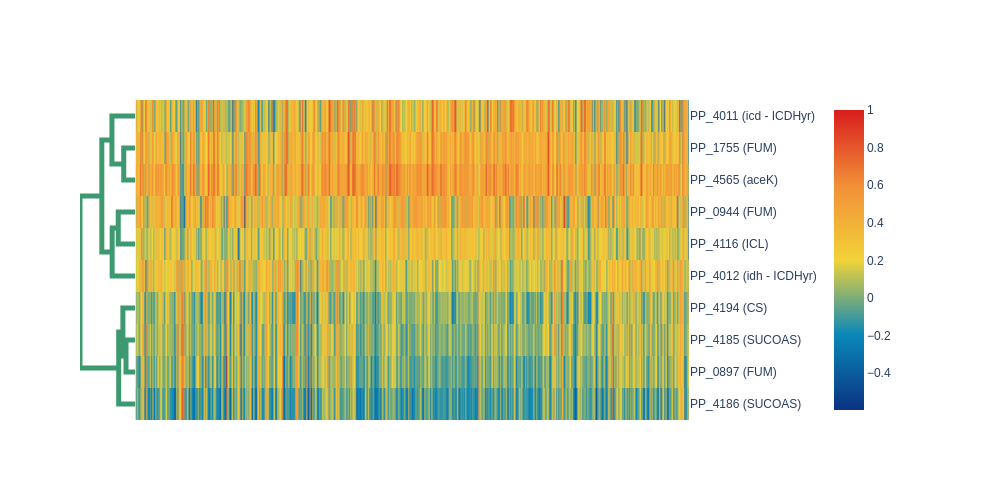

In [12]:
from dash import dcc
import dash_bio as dashbio

clustergram = dashbio.Clustergram(
    data=corr_matrix,
    row_labels= [gpr_map[g] for g in gois],
    column_labels=[gpr_map[g] if g in gpr_map.keys() else g for g in selected_genes],
    color_threshold={
        'row': 250,
        'col': 700
    },
    cluster="row",
    height=800,
    width=700,
    color_map= [
        [0.0, 'rgb(12,51,131)'],
        [0.25, 'rgb(10,136,186)'],
        [0.5, 'rgb(242,211,56)'],
        [0.75, 'rgb(242,143,56)'],
        [1.0, 'rgb(217,30,30)']
    ],
    hidden_labels='col',
    line_width=5,
    display_ratio=0.1,
    center_values=False,
    optimal_leaf_order=True
)


#dcc.Graph(figure=clustergram)
#
clustergram.show(renderer="png", width=1000, height=500) 

In [27]:
clustergram.write_image("figures/corr_00.svg", width=1000, height=500) 

## Clustermap of expression profiles

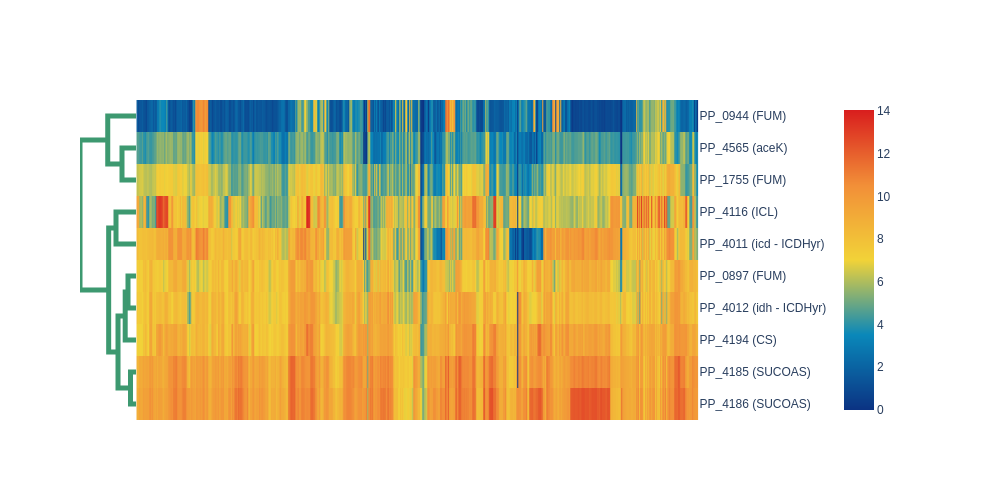

In [14]:
from dash import dcc
import dash_bio as dashbio

clustergram = dashbio.Clustergram(
    data=raw_RNASEQ_data[gois].T.values,
    row_labels= [gpr_map[g] for g in gois],
    column_labels=raw_RNASEQ_data.index.to_list(),
    color_threshold={
        'row': 250,
        'col': 700
    },
    cluster="row",
    height=800,
    width=700,
    color_map= [
        [0.0, 'rgb(12,51,131)'],
        [0.25, 'rgb(10,136,186)'],
        [0.5, 'rgb(242,211,56)'],
        [0.75, 'rgb(242,143,56)'],
        [1.0, 'rgb(217,30,30)']
    ],
    hidden_labels='col',
    line_width=5,
    display_ratio=0.1,
    center_values=False,
    optimal_leaf_order=True
)


#dcc.Graph(figure=clustergram)
#
clustergram.show(renderer="png", width=1000, height=500) 

### Look only for acetate-like conditions (myristic acid study)

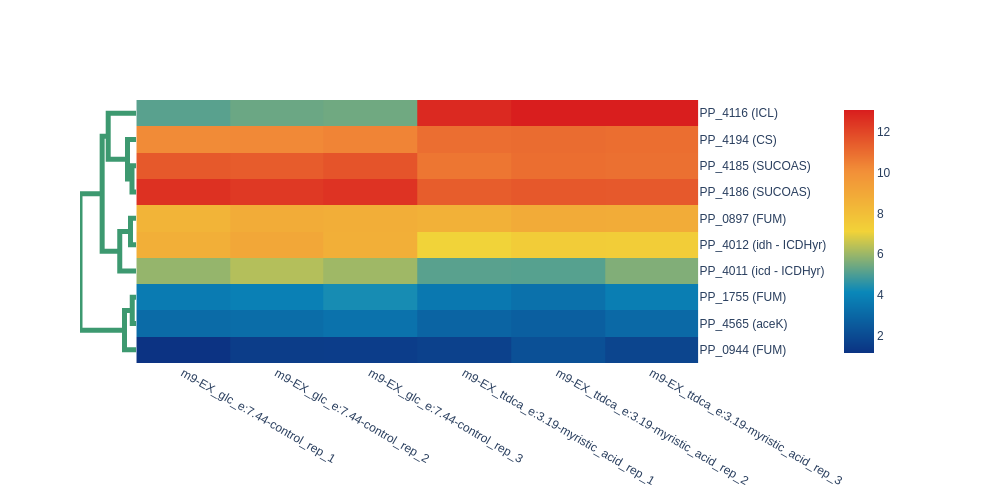

In [50]:
conditions = [c for c_s in expression_data_pseudomonas["Myristic_acid_Study"].values() for c in c_s]

clustergram = dashbio.Clustergram(
    data=raw_RNASEQ_data.loc[conditions, gois].T.values,
    row_labels= [gpr_map[g] for g in gois],
    column_labels=[f"{condition}_rep_{i}" for condition in expression_data_pseudomonas["Myristic_acid_Study"].keys() for i in range(1,4)],
    color_threshold={
        'row': 250,
        'col': 700
    },
    cluster="row",
    height=800,
    width=700,
    color_map= [
        [0.0, 'rgb(12,51,131)'],
        [0.25, 'rgb(10,136,186)'],
        [0.5, 'rgb(242,211,56)'],
        [0.75, 'rgb(242,143,56)'],
        [1.0, 'rgb(217,30,30)']
    ],
    #hidden_labels='col',
    line_width=5,
    display_ratio=0.1,
    center_values=False,
    optimal_leaf_order=True
)


#dcc.Graph(figure=clustergram)
#
clustergram.show(renderer="png", width=1000, height=500) 

In [51]:
clustergram.write_image("figures/log_tpm_myristate_clustering.svg", width=1000, height=500) 

### Look conditions where ICD is repressed an ICL is overexpressed

In [40]:
relevant_columns = ["sample_id", "condition", "full_condition_name", "sample"]
metadata_df = pd.read_csv("data/sample_table.csv")[relevant_columns]
metadata_df

sample_id    condition full_condition_name               sample
0    SRX8894563  GalactoseA5     ALE:GalactoseA5  ALE:GalactoseA5:1.0
1    SRX8894564  GalactoseA5     ALE:GalactoseA5  ALE:GalactoseA5:2.0
2    SRX8894565  GalactoseA6     ALE:GalactoseA6  ALE:GalactoseA6:1.0
3    SRX8894566  GalactoseA6     ALE:GalactoseA6  ALE:GalactoseA6:2.0
4    SRX8894567  GalactoseA8     ALE:GalactoseA8  ALE:GalactoseA8:1.0
..          ...          ...                 ...                  ...
316  ERX1035006         Nano            ZnO:Nano         ZnO:Nano:2.0
317  ERX1035007         Nano            ZnO:Nano         ZnO:Nano:3.0
318  ERX1035009       Zn_ion          ZnO:Zn_ion       ZnO:Zn_ion:1.0
319  ERX1035010       Zn_ion          ZnO:Zn_ion       ZnO:Zn_ion:2.0
320  ERX1035011       Zn_ion          ZnO:Zn_ion       ZnO:Zn_ion:3.0

[321 rows x 4 columns]

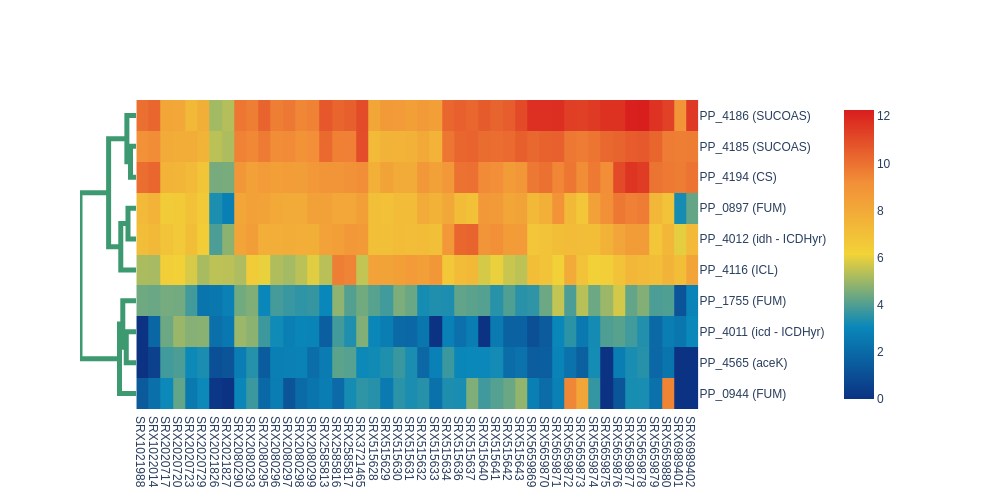

In [45]:
from dash import dcc
import dash_bio as dashbio

icd_low_expression_df = raw_RNASEQ_data.loc[(raw_RNASEQ_data["PP_4011"] < 5) & (raw_RNASEQ_data["PP_4116"] > 5),
                                            gois].T

condition_map = dict(zip(metadata_df["sample_id"], metadata_df["condition"]))

clustergram = dashbio.Clustergram(
    data=icd_low_expression_df.values,
    row_labels= [gpr_map[g] for g in gois],
    column_labels=[condition_map[s] if s in condition_map.keys() else s for s in icd_low_expression_df.columns],
    color_threshold={
        'row': 250,
        'col': 700
    },
    cluster="row",
    height=800,
    width=700,
    color_map= [
        [0.0, 'rgb(12,51,131)'],
        [0.25, 'rgb(10,136,186)'],
        [0.5, 'rgb(242,211,56)'],
        [0.75, 'rgb(242,143,56)'],
        [1.0, 'rgb(217,30,30)']
    ],
    #hidden_labels='col',
    line_width=5,
    display_ratio=0.1,
    center_values=False,
    optimal_leaf_order=True
)


#dcc.Graph(figure=clustergram)
#
clustergram.show(renderer="png", width=1000, height=500) 

In [48]:
clustergram.write_image("figures/Analysis_figures/loW_ICD_high_ICL_conditions.svg", width=1000, height=500) 

There is no metadata for any of the conditions so we can not derive any conclusions. If interested in those samples, search within SRA database to get conitions.

## Flux Sampling of contextualized models of myristic acid study

In [8]:
def limit_bounds(model, limit):
    for r in model.reactions:
        r.bounds = ( max(-limit, r.lower_bound), min(limit, r.upper_bound))
    
    return model

In [ ]:
studies = ['Myristic_acid_Study']

for study in studies:
    for condition in expression_data_pseudomonas[study]:
        if condition not in conditions_to_discard:
            #DEFINE MEDIUM
            media_definition = { 'EX_ca2_e' : 1000,
                                 'EX_cl_e' : 1000,
                                 'EX_co2_e' : 1000,
                                 'EX_cobalt2_e' : 1000,
                                 'EX_cu2_e' : 1000,
                                 'EX_fe2_e' : 1000,
                                 'EX_fe3_e' : 1000,
                                 'EX_h_e' : 1000,
                                 'EX_h2o_e' : 1000,
                                 'EX_k_e' : 1000,
                                 'EX_mg2_e' : 1000,
                                 'EX_mn2_e' : 1000,
                                 'EX_mobd_e' : 1000,
                                 'EX_na1_e' : 1000,
                                 'EX_tungs_e' : 1000,
                                 'EX_zn2_e' : 1000,
                                 'EX_ni2_e' : 1000,
                                 'EX_sel_e' : 1000,
                                 'EX_so4_e' : 1000,
                                 'EX_nh4_e' : 1000,
                                 'EX_pi_e' : 1.024,
                                 'EX_cbl1_e' : .01,
                                 'EX_o2_e' : 20 }
            
            print(condition)
            
            carbon_source = {s.split(':')[0] : float(s.replace('minus', '-').split(':')[1])
                             for s in condition.split('-')[1:]
                             if s.startswith('EX_')}
            
            if "EX_glc_e" in carbon_source.keys():
                uptake = carbon_source["EX_glc_e"]
                del carbon_source['EX_glc_e']
                
                carbon_source[glucose_map["EX_glc_e"]] = uptake
            
            #CONTEXTUALIZE GEM
            context_gem = set_medium(ijn_1462, media_definition, carbon_source) # Set medium
            context_gem = limit_bounds(context_gem, 1000)                       # Limit bounds to -1000 - 1000
            replicates = expression_data_pseudomonas[study][condition]          # Get expression data and
            expression_median = {gene : np.median(ex_reps)                      # Use median expression for context
                                 for gene, ex_reps in zip(RNASEQ_data[gene_column[0]].values,
                                                          RNASEQ_data[replicates].values)}

            result_details, context_gem = create_simplified_GIMME_model(context_gem, expression_median, cutoff=0.1)
            cb.io.save_json_model(context_gem, f"kt_{condition}_gem.json")
            display(result_details)

m9-EX_glc_e:7.44-control
Read LP format model from file /tmp/tmpeq3py9s4.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpj19ppc17.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros


{'3HAD160': 17.229723702,
 '1P2CBXLR': 3.152486571,
 '1PPDCRc': 3.152486571,
 '1PY4h3cAH': 'KO',
 '23CTI1': 4.208897641,
 '23CTI2': 4.208897641,
 '23CTI3': 4.208897641,
 '24DECOAR': 2.397842598,
 '2AACLPGT160': 4.97397369,
 '2AACLPGT161': 4.97397369,
 '2AACLPGT180': 4.97397369,
 '2AACLPGT181': 4.97397369,
 '2AACLPPEAT160': 4.97397369,
 '2AACLPPEAT161': 4.97397369,
 '2AACLPPEAT180': 4.97397369,
 '2AACLPPEAT181': 4.97397369,
 '2AGPE160tipp': 4.97397369,
 '2AGPE161tipp': 4.97397369,
 '2AGPE180tipp': 4.97397369,
 '2AGPE181tipp': 4.97397369,
 '2AGPG160tipp': 4.97397369,
 '2AGPG161tipp': 4.97397369,
 '2AGPG180tipp': 4.97397369,
 '2AGPG181tipp': 4.97397369,
 '2DHGLCK': 6.007262483,
 '2DHGLCNkt_tpp': 8.28420548,
 '34HPPOR': 6.920029819,
 '3AIBT2': 5.343281219,
 '3HAACOAT100': 4.97979483,
 '3HAACOAT120': 4.97979483,
 '3HAACOAT121': 4.97979483,
 '3HAACOAT140': 4.97979483,
 '3HAACOAT141': 4.97979483,
 '3HAACOAT60': 4.97979483,
 '3HAACOAT80': 4.97979483,
 '3HAD100': 17.229723702,
 '3HAD120': 17.22

m9-EX_ttdca_e:3.19-myristic_acid
Read LP format model from file /tmp/tmpqaf_70vi.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpyd5vf5vq.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros


{'3HAD160': 17.662986703,
 '1P2CBXLR': 3.241313042,
 '1PPDCRc': 3.241313042,
 '1PY4h3cAH': 'KO',
 '23CTI1': 10.5704384,
 '23CTI2': 10.5704384,
 '23CTI3': 10.5704384,
 '24DECOAR': 6.364437008,
 '2AACLPGT160': 4.568341704,
 '2AACLPGT161': 4.568341704,
 '2AACLPGT180': 4.568341704,
 '2AACLPGT181': 4.568341704,
 '2AACLPPEAT160': 4.568341704,
 '2AACLPPEAT161': 4.568341704,
 '2AACLPPEAT180': 4.568341704,
 '2AACLPPEAT181': 4.568341704,
 '2AGPE160tipp': 4.568341704,
 '2AGPE161tipp': 4.568341704,
 '2AGPE180tipp': 4.568341704,
 '2AGPE181tipp': 4.568341704,
 '2AGPG160tipp': 4.568341704,
 '2AGPG161tipp': 4.568341704,
 '2AGPG180tipp': 4.568341704,
 '2AGPG181tipp': 4.568341704,
 '2DHGLCK': 'KO',
 '2DHGLCNkt_tpp': 'KO',
 '34HPPOR': 6.218607466,
 '3AIBT2': 4.745011002,
 '3HAACOAT100': 2.583728039,
 '3HAACOAT120': 2.583728039,
 '3HAACOAT121': 2.583728039,
 '3HAACOAT140': 2.583728039,
 '3HAACOAT141': 2.583728039,
 '3HAACOAT60': 2.583728039,
 '3HAACOAT80': 2.583728039,
 '3HAD100': 17.662986703,
 '3HAD120'

In [2]:
from cobra.sampling import OptGPSampler

fs_test_conditions = ['m9-EX_ttdca_e:3.19-myristic_acid', 'm9-EX_glc_e:7.44-control']

condition_map = {
    'm9-EX_ttdca_e:3.19-myristic_acid' : 'myristic_acid',
    'm9-EX_glc_e:7.44-control' : 'glucose'
}

for condition in fs_test_conditions:
    print(condition)
    context_gem = cb.io.load_json_model(f"models/kt_{condition}_gem.json")

    optgp = OptGPSampler(context_gem, processes=4, thinning=10000)
    data = optgp.sample(10000)
    display(data.head())
    data.to_csv(f"results/WT_{condition_map[condition]}_FS.csv", index=False)

m9-EX_ttdca_e:3.19-myristic_acid
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-20
Read LP format model from file /tmp/tmpvab41obm.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros


3HAD160  13DAMPPabcpp  13DAMPPtex  15DAPabcpp  1P2CBXLCYCL      1P2CBXLR  \
0  0.052611           0.0         0.0         0.0          0.0  4.303010e-21   
1  0.050503           0.0         0.0         0.0          0.0  4.057160e-21   
2  0.051404           0.0         0.0         0.0          0.0  3.370444e-21   
3  0.468529           0.0         0.0         0.0          0.0  6.927508e-16   
4  0.935879           0.0         0.0         0.0          0.0 -7.003471e-15   

        1PPDCRc         1PQQS  1PY4h3cAH        23CTI1  ...  4HPRODCabcpp  \
0  2.504795e-07  3.012076e-10        0.0  4.356603e-07  ...           0.0   
1  4.647578e-05  1.467832e-08        0.0  3.247533e-07  ...           0.0   
2  4.643531e-05  1.594768e-08        0.0  1.493823e-08  ...           0.0   
3  4.032524e-02  2.183996e-06        0.0  3.126965e-01  ...           0.0   
4  1.772626e-02  1.290651e-06        0.0  2.951595e-01  ...           0.0   

   4HPRODCtex  4HPROE  4HPROLTabcpp  4HPROLTtex  4HTHRS  4MBZALDH  4MBZDH  \
0         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
1         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
2         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
3         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
4         0.0     0.0           0.0         0.0     0.0       0.0     0.0   

   4MCAT23DOX  4OD  
0         0.0  0.0  
1         0.0  0.0  
2         0.0  0.0  
3         0.0  0.0  
4         0.0  0.0  

[5 rows x 2927 columns]

m9-EX_glc_e:7.44-control
Read LP format model from file /tmp/tmptjqk5qqm.lp
Reading time = 0.02 seconds
: 2153 rows, 5854 columns, 23272 nonzeros


3HAD160  13DAMPPabcpp  13DAMPPtex  15DAPabcpp  1P2CBXLCYCL  1P2CBXLR  \
0  14.551112           0.0         0.0         0.0          0.0       0.0   
1  14.550735           0.0         0.0         0.0          0.0       0.0   
2  14.550867           0.0         0.0         0.0          0.0       0.0   
3   1.038994           0.0         0.0         0.0          0.0       0.0   
4   1.038940           0.0         0.0         0.0          0.0       0.0   

        1PPDCRc         1PQQS  1PY4h3cAH    23CTI1  ...  4HPRODCabcpp  \
0  4.931637e-07  1.029683e-06        0.0  0.000002  ...           0.0   
1  6.321258e-07  1.032876e-06        0.0  0.000002  ...           0.0   
2  6.052235e-07  1.035411e-06        0.0  0.000002  ...           0.0   
3  3.080270e-07  5.275814e-07        0.0  0.000036  ...           0.0   
4  2.840468e-07  5.256366e-07        0.0  0.000017  ...           0.0   

   4HPRODCtex  4HPROE  4HPROLTabcpp  4HPROLTtex  4HTHRS  4MBZALDH  4MBZDH  \
0         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
1         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
2         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
3         0.0     0.0           0.0         0.0     0.0       0.0     0.0   
4         0.0     0.0           0.0         0.0     0.0       0.0     0.0   

   4MCAT23DOX  4OD  
0         0.0  0.0  
1         0.0  0.0  
2         0.0  0.0  
3         0.0  0.0  
4         0.0  0.0  

[5 rows x 2927 columns]

In [58]:
reactions_of_interest = ["ICL", "CS", "ICDHyr", "SUCDi"]

fs_result_wt = pd.read_csv("Results/WT_glucose_FS.csv")
fs_result_wt["Condition"] = ["Glucose"]*len(fs_result_wt)
fs_result_ma = pd.read_csv("Results/WT_myristic_acid_FS.csv")
fs_result_ma["Condition"] = ["Myristic Acid"]*len(fs_result_ma)

fs_df = pd.concat([fs_result_wt[reactions_of_interest+["Condition"]],
                   fs_result_ma[reactions_of_interest+["Condition"]]])

fs_df

ICL         CS    ICDHyr      SUCDi      Condition
0       0.886381   5.593541  4.700592   5.698518        Glucose
1       0.683527   5.383560  4.658157   5.529575        Glucose
2       1.412326   5.847083  4.373255   5.764368        Glucose
3       1.617112   5.889134  4.204398   5.862919        Glucose
4       1.536076   5.870546  4.252300   6.109043        Glucose
...          ...        ...       ...        ...            ...
10003  10.851475  11.456674  0.571539  11.470299  Myristic Acid
10004  10.632788  11.207365  0.491972  11.177080  Myristic Acid
10005  11.279550  11.404471  0.050218  11.325457  Myristic Acid
10006  10.381668  10.937899  0.472886  11.163011  Myristic Acid
10007  12.136650  11.734935 -0.441702  12.097927  Myristic Acid

[20016 rows x 5 columns]

In [59]:
fs_df.describe()

ICL            CS        ICDHyr         SUCDi
count  20016.000000  20016.000000  20016.000000  20016.000000
mean       4.924651      7.405612      2.359215      7.390427
std        3.265264      2.172074      1.374133      2.126337
min        0.015567      0.662985    -17.442009      0.623508
25%        1.760791      5.457077      1.360605      5.476218
50%        5.098649      7.344622      2.198816      7.320857
75%        7.886322      9.416578      3.479120      9.343293
max       33.402439     20.392755      6.325955     20.264622

In [60]:
import plotly.figure_factory as ff
import plotly.express as px

conditions = ["Glucose", "Myristic Acid"]

for condition in conditions:
    plot_df = fs_df.loc[fs_df["Condition"]==condition]
    # Create distplot with curve_type set to 'normal'
    fig = ff.create_distplot(plot_df[reactions_of_interest].values.T,
                             plot_df.columns.tolist()[:-1],
                             bin_size=.2, show_rug=False,
                             colors=px.colors.qualitative.Prism)

    fig.update_layout(template="simple_white",
                      height=400,
                      width=800,
                      )
    
    fig.update_xaxes(title_text="Flux", range=[-5, 15], linewidth=3)
    fig.update_yaxes(title_text="Probability Density", linewidth=3)

    fig.show()
    fig.write_image(f"FS_{condition}_result.svg")